In [1]:
# Import the libraries

import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
from pandas.io.json import json_normalize

## Authorization Flow

In [2]:
# Declare the credentials
CLIENT_ID = # id do client da api
CLIENT_SECRET = # token do cilent da api
redirect_uri='http://localhost:7777/callback'
username = # seu username no spotify - Não é seu nome! Isso está disponível na parte Conta na platforma

# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=CLIENT_ID, client_secret=CLIENT_SECRET, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

## Extract User's Top Medium Term Songs

In [4]:
user_songs = pd.read_csv('User_top_50_songs.csv')
user_songs.reset_index(drop=True,inplace=True)
user_songs.head()

,Unnamed: 0,artist,artist_uri,song,song_uri,duration_ms,explicit,album,popularity
0,0,Glee Cast,spotify:artist:0SCbttzoZTnLFebDYmAWCm,Science Fiction Double Feature (Glee Cast Vers...,spotify:track:4i3CKKl6S3fNkyGsgtJAss,267986,False,"Glee: The Music, The Rocky Horror Glee Show",42
1,1,Glee Cast,spotify:artist:0SCbttzoZTnLFebDYmAWCm,Sweet Transvestite (Glee Cast Version),spotify:track:5Uaz86QcbGZgTyS5sh6TmM,179920,False,"Glee: The Music, The Rocky Horror Glee Show",47
2,2,Glee Cast,spotify:artist:0SCbttzoZTnLFebDYmAWCm,Whatever Happened To Saturday Night? (Glee Cas...,spotify:track:3wZD98XkyFfkB2jHIORDnY,184400,False,"Glee: The Music, The Rocky Horror Glee Show",43
3,3,Glee Cast,spotify:artist:0SCbttzoZTnLFebDYmAWCm,Touch A Touch A Touch A Touch Me (Glee Cast Ve...,spotify:track:4QhUwFhOCM0qpORDogzvDs,149626,False,"Glee: The Music, The Rocky Horror Glee Show",49
4,4,Glee Cast,spotify:artist:0SCbttzoZTnLFebDYmAWCm,Time Warp (Glee Cast Version),spotify:track:1onMcvjW2nZ2dHtbJn2cN7,193560,False,"Glee: The Music, The Rocky Horror Glee Show",57


## Extract Users' Top 50 Tracks' Audio Features

In [5]:
user_list = []
for song in user_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user_list.append(row)
user_df = pd.concat(user_list)

user_df.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.2820,https://api.spotify.com/v1/audio-analysis/4i3C...,0.428,267987,0.559,4i3CKKl6S3fNkyGsgtJAss,0.000000,0,0.382,-7.052,1,0.0246,90.198,4,https://api.spotify.com/v1/tracks/4i3CKKl6S3fN...,audio_features,spotify:track:4i3CKKl6S3fNkyGsgtJAss,0.361
0,0.4510,https://api.spotify.com/v1/audio-analysis/5Uaz...,0.736,179920,0.571,5Uaz86QcbGZgTyS5sh6TmM,0.000618,4,0.223,-3.942,1,0.0457,107.788,4,https://api.spotify.com/v1/tracks/5Uaz86QcbGZg...,audio_features,spotify:track:5Uaz86QcbGZgTyS5sh6TmM,0.554
0,0.1180,https://api.spotify.com/v1/audio-analysis/3wZD...,0.566,184400,0.913,3wZD98XkyFfkB2jHIORDnY,0.000005,3,0.194,-4.607,1,0.0577,164.982,4,https://api.spotify.com/v1/tracks/3wZD98XkyFfk...,audio_features,spotify:track:3wZD98XkyFfkB2jHIORDnY,0.961
0,0.2610,https://api.spotify.com/v1/audio-analysis/4QhU...,0.309,149627,0.789,4QhUwFhOCM0qpORDogzvDs,0.000068,10,0.163,-6.232,0,0.0457,170.713,4,https://api.spotify.com/v1/tracks/4QhUwFhOCM0q...,audio_features,spotify:track:4QhUwFhOCM0qpORDogzvDs,0.606
0,0.0442,https://api.spotify.com/v1/audio-analysis/1onM...,0.395,193560,0.817,1onMcvjW2nZ2dHtbJn2cN7,0.000072,11,0.243,-5.757,0,0.1250,176.196,4,https://api.spotify.com/v1/tracks/1onMcvjW2nZ2...,audio_features,spotify:track:1onMcvjW2nZ2dHtbJn2cN7,0.635


## Data Cleaning

In [6]:
# Drop unnecessary features

user_df.drop(['type','track_href','analysis_url','time_signature','duration_ms','uri','instrumentalness','liveness','loudness','key','mode'],1,inplace=True)
user_df.set_index('id',inplace=True)
user_df.head()

,acousticness,danceability,energy,speechiness,tempo,valence
id,,,,,,
4i3CKKl6S3fNkyGsgtJAss,0.2820,0.428,0.559,0.0246,90.198,0.361
5Uaz86QcbGZgTyS5sh6TmM,0.4510,0.736,0.571,0.0457,107.788,0.554
3wZD98XkyFfkB2jHIORDnY,0.1180,0.566,0.913,0.0577,164.982,0.961
4QhUwFhOCM0qpORDogzvDs,0.2610,0.309,0.789,0.0457,170.713,0.606
1onMcvjW2nZ2dHtbJn2cN7,0.0442,0.395,0.817,0.1250,176.196,0.635


In [7]:
# Normalize tempo feature

columns = ['danceability','energy','speechiness','acousticness','valence','tempo']
scaler = MinMaxScaler()
scaler.fit(user_df[columns])
user_df[columns] = scaler.transform(user_df[columns])
user_df.head()

,acousticness,danceability,energy,speechiness,tempo,valence
id,,,,,,
4i3CKKl6S3fNkyGsgtJAss,0.301976,0.278057,0.500595,0.000000,0.114251,0.274486
5Uaz86QcbGZgTyS5sh6TmM,0.497284,0.793970,0.514863,0.083930,0.273495,0.507860
3wZD98XkyFfkB2jHIORDnY,0.112447,0.509213,0.921522,0.131663,0.791280,1.000000
4QhUwFhOCM0qpORDogzvDs,0.277707,0.078727,0.774078,0.083930,0.843164,0.570738
1onMcvjW2nZ2dHtbJn2cN7,0.027158,0.222781,0.807372,0.399364,0.892802,0.605804


In [9]:
# Check out features summary

user_df.describe()

,acousticness,danceability,energy,speechiness,tempo,valence
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.457196,0.540771,0.679334,0.139642,0.447134,0.592213
std,0.252058,0.230524,0.230429,0.190841,0.273522,0.270690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.271351,0.458124,0.567776,0.025060,0.207133,0.355200
50%,0.482260,0.567002,0.739596,0.052904,0.474665,0.626965
75%,0.609095,0.685930,0.821938,0.168755,0.566436,0.792624
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Distributions of Combined Audio Features


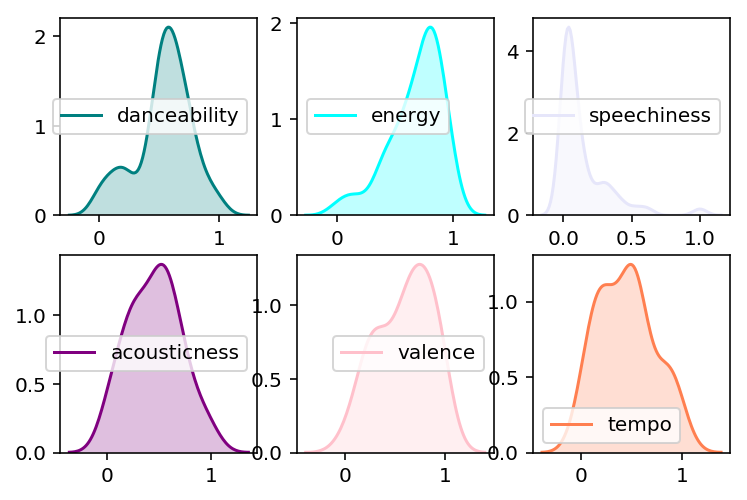

In [10]:
# Visualizing distribution of audio features of our combined songs
print("Distributions of Combined Audio Features")
plt.subplot(2,3,1)
sns.kdeplot(data=user_df.danceability,shade=True,color='teal')
plt.subplot(2,3,2)
sns.kdeplot(data=user_df.energy,shade=True,color='cyan')
plt.subplot(2,3,3)
sns.kdeplot(data=user_df.speechiness,shade=True,color='lavender')
plt.subplot(2,3,4)
sns.kdeplot(data=user_df.acousticness,shade=True,color='purple')
plt.subplot(2,3,5)
sns.kdeplot(data=user_df.valence,shade=True,color='pink')
plt.subplot(2,3,6)
sns.kdeplot(data=user_df.tempo,shade=True,color='coral')

In [11]:
#Making into A CSV

user_df.to_csv('User_top_50_song_features.csv')